# Annotation Analysis and Consensus

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from scipy import signal as sig
from scipy.integrate import simpson
from scipy.signal import coherence
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize
from itertools import chain
import scipy as sc
from bct.algorithms import community_louvain
from statannot import add_stat_annotation
plt.rcParams['image.cmap'] = 'magma'

# ML Imports
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF,ConstantKernel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF
from sklearn.utils import resample
from sklearn.metrics import cohen_kappa_score
from krippendorff import alpha
import pingouin as pg

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
import pathlib
from tqdm import tqdm
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
import mne

import os
os.environ["ETS_TOOLKIT"] = "qt4"
os.environ["QT_API"] = "pyqt5"

In [2]:
usr,passpath,datapath,prodatapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

## Workspace Preparation

In [3]:
# Loading seizure onset meta data
sz_metadata = pd.read_csv(ospj(datapath,'stim_seizure_information - LF_seizure_annotation.csv'))
sz_metadata.replace({np.nan:pd.NA},inplace=True)

In [4]:
# Setting plotting parameters
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width

## Seizure Annotator Analysis

### Preparing annotation table

In [5]:
annotators = np.sort(['EC','CK','DZ','JJ','JK']) # annotator list
time_labels = ['UEO_time'] # onset time label
clinician_tables = {}
for clin in annotators:
    # Load in secondary annotation push
    annot_table = pd.read_csv(ospj(datapath,f"stim_seizure_annotations_{clin}.csv"))
    # Load in annotations from initial assessment
    demo_table = pd.read_csv(ospj(datapath,f"stim_seizure_information - {clin}_annotation_demo.csv"))
    # Unifying onset column name
    demo_table.columns = [c if c != 'Onset' else 'approximate_onset' for c in demo_table.columns]
    # Aggregating tables across clinicians and annotation sections
    clinician_tables[clin] = []
    clinician_tables[clin].append(annot_table)
    clinician_tables[clin].append(demo_table)
# Organizing dataframes into a list for concatenation
df_list = [df for l in clinician_tables.values() for df in l]
# Getting annotator key for each DF
key_list = np.array([[key]*2 for key in clinician_tables.keys()]).flatten()

# Combining DFs
combined_df = pd.concat(df_list, keys=key_list, names=['Clinician'])

# Reset index to avoid having MultiIndex
combined_df.reset_index(inplace=True)

# Drop nan rows from csv loading
combined_df = combined_df.dropna(axis=0,how='any',subset=['UEO_ch'])

# Create a unique identifier for each seizure
combined_df['Seizure_ID'] = combined_df.groupby(['Patient', 'Clinician']).cumcount() + 1
combined_df['Seizure_ID'] = combined_df['Patient'] + '_' + combined_df['Seizure_ID'].astype(int).astype(str)
combined_df = combined_df.drop(['level_1'],axis=1)


# Turning strings of channels to a list
combined_df['UEO_ch'] = combined_df['UEO_ch'].str.split(',')
combined_df['10sec_ch'] = combined_df['10sec_ch'].str.split(',')

In [6]:
# Combining annotations across a seiuzre at the channel level
def combine_ch_annots(group):
    ret = {"clinician": [],
           "patient": [],
           "ueo": [],
           "ueo_time": [],
           "sec": []
          }
    # Sorting seizure annotations by clinician
    group.sort_values(by='Clinician',inplace=True)
    # Unifying and extracting iEEG name
    group['IEEGname'] = group['IEEGname'].fillna(method='ffill').fillna(method='bfill')
    ieeg_name = group['IEEGname'].iloc[0]
    pt = group['Patient'].iloc[0]
    # Get all channels from iEEG portal
    with open('woj_ieeglogin.bin', 'r') as f:
        session = Session('wojemann', f.read())
    ds = session.open_dataset(ieeg_name)
    # Clean channel labels
    raw_labels = clean_labels(ds.get_channel_labels(),pt)
    # Remove scalp electrodes from channels
    all_chs = remove_scalp_electrodes(raw_labels)

    for _,row in group.iterrows(): # for each annotation in seizure
        for i,v in row.items(): # for each column in annotation
            if not isinstance(v,list): # filling in nan's as empty list to ensure formatting consistency
                if pd.isna(v):
                    row[i] = []
        # Adding anntotor and patient data
        ret["clinician"].append(row.Clinician)
        ret["patient"] = row.Patient
        # Adding UEO and Spread channel ifnormation
        ret["ueo"].append([l in clean_labels(row.UEO_ch,pt) for l in all_chs])
        ret["sec"].append([l in clean_labels(row["10sec_ch"],pt) for l in all_chs])
        # Adding anntotated start time
        ret["ueo_time"].append(float(row.UEO_time))
        
    # Adding in additional patient metadata to table from originnal stim seizure metadata
    ret["all_chs"] = all_chs
    ret["iEEG_ID"] = row["IEEGname"]
    ret["approximate_onset"] = row["approximate_onset"]
    ret["offset"] = row["end"]
    ret["stim"] = row["stim"]
        
    return pd.Series(ret)

In [7]:
# Applying function to combine channel annotations across annotators to get one row per seizure
combined_annots = combined_df.groupby('Seizure_ID').apply(combine_ch_annots).reset_index()

In [8]:
# Removing seizures if a clinician did not think it was sufficiently a seizure
combined_annots_reduced = combined_annots[combined_annots.clinician.apply(lambda x: len(x)) > 2]
combined_annots_reduced.head()

,Seizure_ID,clinician,patient,ueo,ueo_time,sec,all_chs,iEEG_ID,approximate_onset,offset,stim
0,CHOP005_1,"[CK, JJ, JK]",CHOP005,"[[False, False, False, False, False, False, Fa...","[68881.44, 68881.52, 68881.26]","[[False, False, False, False, False, False, Fa...","[LA01, LA10, LA02, LA03, LA04, LA05, LA06, LA0...",CHOP005,68881.53,68944.57,1.0
1,CHOP010_1,"[DZ, EC, JK]",CHOP010,"[[False, False, False, False, False, False, Fa...","[2232.773277, 2232.6, 2232.77]","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_010,2230.26,2267.78,1.0
2,CHOP015_1,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[77180.36, 77180.95, 77190.4]","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_015,77190.79,77225.07,1.0
3,CHOP015_2,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[81584.13, 81587.68, 81587.23]","[[False, False, False, True, True, False, Fals...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_015,81585.72,81614.99,0.0
4,CHOP024_1,"[CK, DZ, JJ]",CHOP024,"[[False, False, False, False, False, False, Fa...","[87577.58, 875775.9034, 87576.74]","[[False, False, False, False, False, False, Fa...","[LA01, LA10, LA02, LA03, LA04, LA05, LA06, LA0...",CHOPCCEP_024,87579.25,87591.61,1.0


In [9]:
x = combined_annots[combined_annots.patient == 'CHOP024'][["sec"]].to_numpy()[0]

In [10]:
[sum(y) for y in x[0]]

[0, 0, 0]

### Calculating clinician kappas

In [11]:
# Calculate the kappa value between each pair of clinicians for each seizure
def pairwise_kappa(row):
    row_idxs = [i for i in row.index if i in ["ueo","sec"]] # extracting indices for annotations
    for ch_type in row_idxs:
        all_kappas = np.ones((len(row[ch_type]),len(row[ch_type])))*2 # initializing kappas
        chs = row[ch_type] # getting list of all annotations for that seizure and annot type
        for i in range(len(chs)): # getting first annotator
            for j in range(i+1,len(chs)): # getting second annotator
                all_kappas[i,j] = cohen_kappa_score(chs[i],chs[j]) # calculating agreement
                if ch_type == 'ueo': # adding to collection for plotting
                    ANNOT_ALL_SZ[row.clinician[i]].append(all_kappas[i,j])
                    ANNOT_ALL_SZ[row.clinician[j]].append(all_kappas[i,j])
        # # optional code to plot a heat-map per seizure
        # plt.figure()
        # sns.heatmap(all_kappas,annot=True,fmt=".2f",cmap="magma",xticklabels=row.clinician,yticklabels=row.clinician,vmin=0,vmax=1)
        # plt.title(f"{row.name}: {ch_type}")
        # Assigning kappas matrix for that seizure and annot type
        row[f"{ch_type}_kappas"] = all_kappas

    return row

In [12]:
# Function for plotting the agreement that each clinician has with the other clinicians on average
def plot_kappas_by_clinician(ANNOT_ALL_SZ):
    max_length = max(len(arr) for arr in ANNOT_ALL_SZ.values())
    for key in ANNOT_ALL_SZ.keys():
        ANNOT_ALL_SZ[key] += [np.nan] * (max_length - len(ANNOT_ALL_SZ[key]))
    plotting_df = pd.DataFrame.from_dict(ANNOT_ALL_SZ).melt()
    sns.boxplot(plotting_df,x='variable',y='value',palette='flare')
    # plt.xticks(np.arange(len(annotators)),annotators)
    plt.title("UEO Cohen's Kappa by Annotator")
    plt.ylabel('Cohen\'s Kappa')
    plt.xlabel('Clinician Annotator')

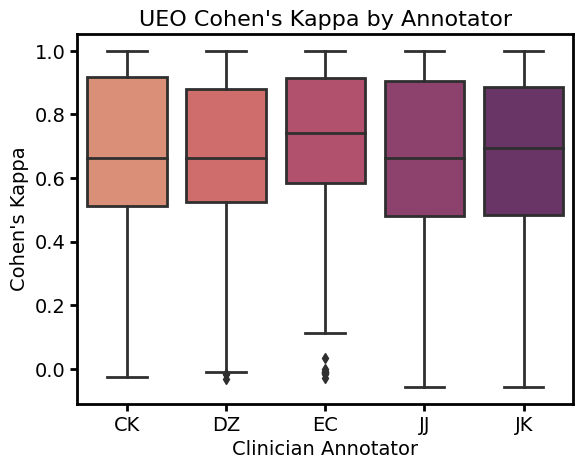

In [13]:
# All
ANNOT_ALL_SZ = {i:[] for i in annotators}
kappa_annots = combined_annots_reduced.apply(pairwise_kappa,axis=1).reset_index(drop=True)
plot_kappas_by_clinician(ANNOT_ALL_SZ)

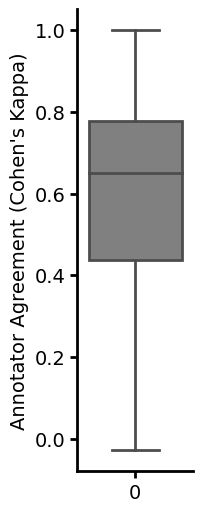

In [14]:
np.mean(np.triu(kappa_annots[['ueo_kappas']].iloc[0,0],1))
data = []
for i in range(len(kappa_annots)):
    mat = kappa_annots[['ueo_kappas']].iloc[i,0]
    val = np.nanmean([k if k != 2 else np.nan for k in mat.flatten()])
    data.append(val)
data = np.array(data)
plt.figure(figsize=(1.5,6))
plt.tight_layout()
sns.boxplot(data,color='grey')
plt.ylabel('Annotator Agreement (Cohen\'s Kappa)')
sns.despine()
plt.savefig(ospj(figpath,'all_annotator_ueo_kappa.pdf'),bbox_inches='tight')

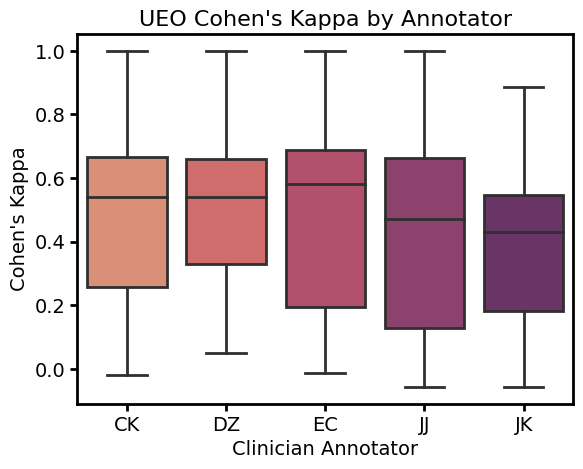

In [15]:
# CHOP
ANNOT_ALL_SZ = {i:[] for i in annotators}
kappa_annots_chop = combined_annots_reduced[combined_annots_reduced.patient.apply(lambda x: x[:-3]) == 'CHOP'].apply(pairwise_kappa,axis=1).reset_index(drop=True)
plot_kappas_by_clinician(ANNOT_ALL_SZ)

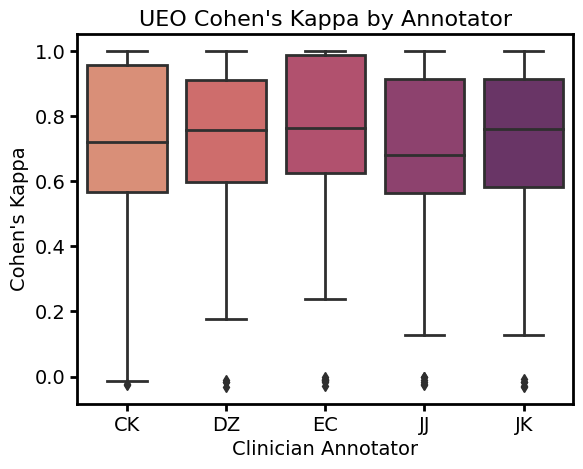

In [16]:
# HUP
ANNOT_ALL_SZ = {i:[] for i in annotators}
kappa_annots_hup = combined_annots_reduced[combined_annots_reduced.patient.apply(lambda x: x[:-3]) != 'CHOP'].apply(pairwise_kappa,axis=1).reset_index(drop=True)
plot_kappas_by_clinician(ANNOT_ALL_SZ)

### Calculating seizure level agreement

In [17]:
def sz_level_agreement(row):
    row_idxs = [i for i in row.index if 'kappas' in i]
    for chtype in row_idxs:
        row[f"{chtype[:-7]}_avg"] = np.mean(row[chtype][row[chtype] != 2])
    return row
kappa_avg = kappa_annots.apply(sz_level_agreement,axis=1)
kappa_avg.head()

,Seizure_ID,clinician,patient,ueo,ueo_time,sec,all_chs,iEEG_ID,approximate_onset,offset,stim,ueo_kappas,sec_kappas,ueo_avg,sec_avg
0,CHOP005_1,"[CK, JJ, JK]",CHOP005,"[[False, False, False, False, False, False, Fa...","[68881.44, 68881.52, 68881.26]","[[False, False, False, False, False, False, Fa...","[LA01, LA10, LA02, LA03, LA04, LA05, LA06, LA0...",CHOP005,68881.53,68944.57,1.0,"[[2.0, 0.7443820224719101, 0.6583229036295369]...","[[2.0, 0.42435424354243545, 0.5687203791469194...",0.762938,0.507339
1,CHOP010_1,"[DZ, EC, JK]",CHOP010,"[[False, False, False, False, False, False, Fa...","[2232.773277, 2232.6, 2232.77]","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_010,2230.26,2267.78,1.0,"[[2.0, 0.18894009216589858, 0.5230352303523036...","[[2.0, 0.17039106145251393, 0.7622478386167147...",0.232717,0.354422
2,CHOP015_1,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[77180.36, 77180.95, 77190.4]","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_015,77190.79,77225.07,1.0,"[[2.0, -0.014084507042253724, -0.0152284263959...","[[2.0, 0.5, 0.5473251028806584], [2.0, 2.0, 0....",-0.028639,0.515775
3,CHOP015_2,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[81584.13, 81587.68, 81587.23]","[[False, False, False, True, True, False, Fals...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_015,81585.72,81614.99,0.0,"[[2.0, 1.0, 0.3918918918918919], [2.0, 2.0, 0....","[[2.0, 0.4744525547445255, 0.7567567567567568]...",0.594595,0.530466
4,CHOP024_1,"[CK, DZ, JJ]",CHOP024,"[[False, False, False, False, False, False, Fa...","[87577.58, 875775.9034, 87576.74]","[[False, False, False, False, False, False, Fa...","[LA01, LA10, LA02, LA03, LA04, LA05, LA06, LA0...",CHOPCCEP_024,87579.25,87591.61,1.0,"[[2.0, 0.48051948051948057, -0.020408163265306...","[[2.0, nan, nan], [2.0, 2.0, nan], [2.0, 2.0, ...",0.268635,NaN


Text(0.5, 1.0, "Average Channel Agreement (Cohen's Kappa) per Seizure")

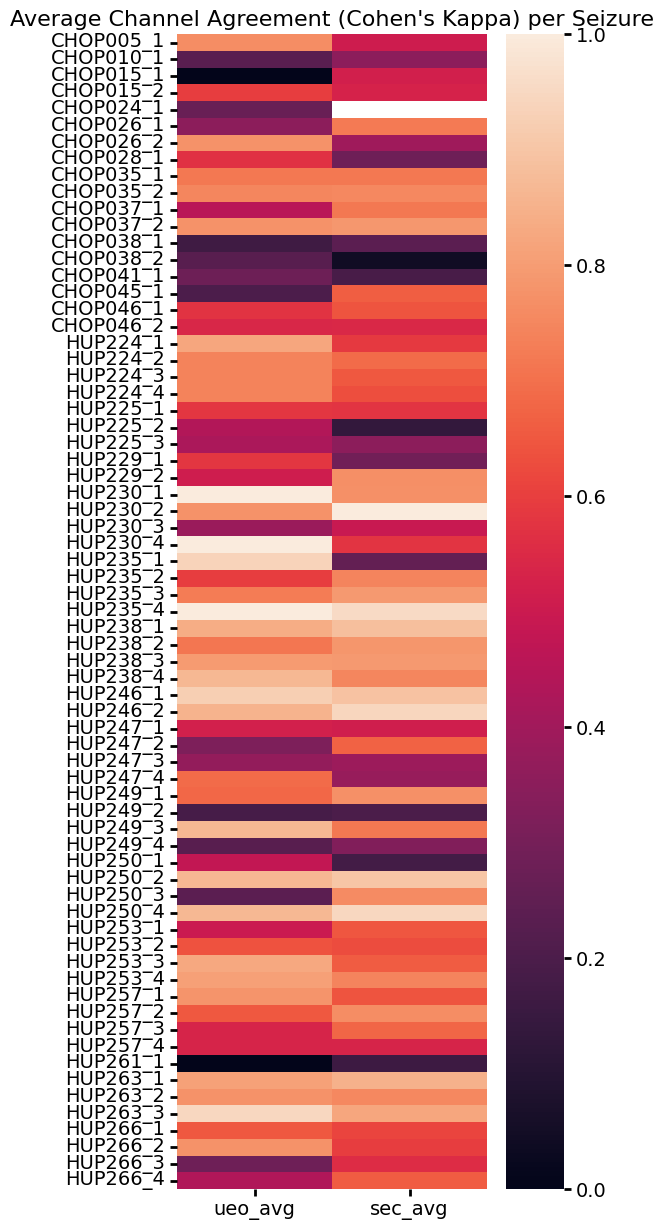

In [18]:
fig,ax = plt.subplots(figsize=(5,15))
# fig.figsize = (15,5)
sns.heatmap(kappa_avg.iloc[:,-2:],yticklabels=kappa_avg.Seizure_ID,vmin=0,vmax=1)
plt.title("Average Channel Agreement (Cohen\'s Kappa) per Seizure")

### Creating clinician consensus

In [19]:
def create_consensus(row):
    for key in ["ueo","sec"]:
        row[f"{key}_consensus"] = np.array(np.sum(np.array(row[key]).astype(int),axis=0) >= 2).astype(bool)
        row[f"{key}_any"] = np.array(np.sum(np.array(row[key]).astype(int),axis=0) >= 1).astype(bool)
        if key == 'ueo':
            row[f"{key}_time_consensus"] = np.median(row[f"{key}_time"])
    return row

In [20]:
consensus_annots = combined_annots.apply(create_consensus,axis=1)
consensus_annots.head()

,Seizure_ID,clinician,patient,ueo,ueo_time,sec,all_chs,iEEG_ID,approximate_onset,offset,stim,ueo_consensus,ueo_any,ueo_time_consensus,sec_consensus,sec_any
0,CHOP005_1,"[CK, JJ, JK]",CHOP005,"[[False, False, False, False, False, False, Fa...","[68881.44, 68881.52, 68881.26]","[[False, False, False, False, False, False, Fa...","[LA01, LA10, LA02, LA03, LA04, LA05, LA06, LA0...",CHOP005,68881.53,68944.57,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",68881.44,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
1,CHOP010_1,"[DZ, EC, JK]",CHOP010,"[[False, False, False, False, False, False, Fa...","[2232.773277, 2232.6, 2232.77]","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_010,2230.26,2267.78,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2232.77,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
2,CHOP015_1,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[77180.36, 77180.95, 77190.4]","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_015,77190.79,77225.07,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",77180.95,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
3,CHOP015_2,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[81584.13, 81587.68, 81587.23]","[[False, False, False, True, True, False, Fals...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_015,81585.72,81614.99,0.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",81587.23,"[False, False, False, True, True, False, False...","[False, False, True, True, True, True, False, ..."
4,CHOP024_1,"[CK, DZ, JJ]",CHOP024,"[[False, False, False, False, False, False, Fa...","[87577.58, 875775.9034, 87576.74]","[[False, False, False, False, False, False, Fa...","[LA01, LA10, LA02, LA03, LA04, LA05, LA06, LA0...",CHOPCCEP_024,87579.25,87591.61,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",87577.58,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."


In [21]:
consensus_annots.to_csv(ospj(prodatapath,"stim_seizure_information_consensus.csv"),index=False)
consensus_annots.to_pickle(ospj(prodatapath,"stim_seizure_information_consensus.pkl"))

## Manual annotation analysis

In [22]:
consensus_annots = pd.read_pickle(ospj(prodatapath,'stim_seizure_information_consensus.pkl'))
consensus_annots.head()

,Seizure_ID,clinician,patient,ueo,ueo_time,sec,all_chs,iEEG_ID,approximate_onset,offset,stim,ueo_consensus,ueo_any,ueo_time_consensus,sec_consensus,sec_any
0,CHOP005_1,"[CK, JJ, JK]",CHOP005,"[[False, False, False, False, False, False, Fa...","[68881.44, 68881.52, 68881.26]","[[False, False, False, False, False, False, Fa...","[LA01, LA10, LA02, LA03, LA04, LA05, LA06, LA0...",CHOP005,68881.53,68944.57,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",68881.44,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
1,CHOP010_1,"[DZ, EC, JK]",CHOP010,"[[False, False, False, False, False, False, Fa...","[2232.773277, 2232.6, 2232.77]","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_010,2230.26,2267.78,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2232.77,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
2,CHOP015_1,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[77180.36, 77180.95, 77190.4]","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_015,77190.79,77225.07,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",77180.95,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
3,CHOP015_2,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[81584.13, 81587.68, 81587.23]","[[False, False, False, True, True, False, Fals...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_015,81585.72,81614.99,0.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",81587.23,"[False, False, False, True, True, False, False...","[False, False, True, True, True, True, False, ..."
4,CHOP024_1,"[CK, DZ, JJ]",CHOP024,"[[False, False, False, False, False, False, Fa...","[87577.58, 875775.9034, 87576.74]","[[False, False, False, False, False, False, Fa...","[LA01, LA10, LA02, LA03, LA04, LA05, LA06, LA0...",CHOPCCEP_024,87579.25,87591.61,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",87577.58,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."


### Channels

MannwhitneyuResult(statistic=353.0, pvalue=0.0005969969641447577)
-0.8492935219648827


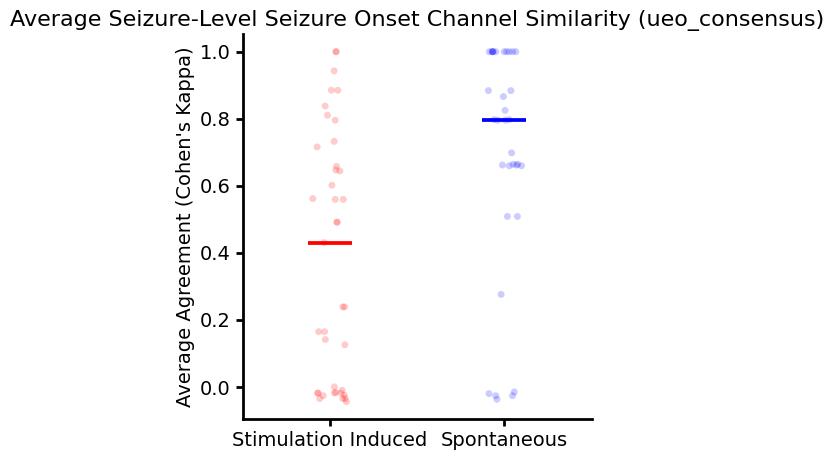

In [23]:
# Can also toggle median or mean within patients
all_stim_annots = []
all_spont_annots = []
avg_stim_annots = []
avg_spont_annots = []
annot_type = 'ueo'
con_type = 'consensus'
for pt,group in consensus_annots.groupby("patient"):
    # if sum(group.stim == 0) < 2:
    #     print(f"Skipping {pt} due to insufficient manually annotated spontaneous seizures")
    #     continue
    
    if len(group) < 2:
        continue

    spont_dices=[]
    stim_dices=[]
    spont_kappas=[]
    stim_kappas=[]
    for i in range(len(group)):
        group.reset_index(drop=True,inplace=True)
        ch_mask = group.loc[i,f'{annot_type}_{con_type}']
        # print(ch_mask)
        chs = np.array(group.loc[i,'all_chs'])[ch_mask]
        for j in range(i+1,len(group)):
            if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                continue
            ch_mask2 = group.loc[j,f'{annot_type}_{con_type}']
            chs2 = np.array(group.iloc[j,6])[ch_mask2]
            if (group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1):
                stim_dices.append(dice_score(chs,chs2))
                stim_kappas.append(cohen_kappa_score(ch_mask,ch_mask2))
            else:
                spont_dices.append(dice_score(chs,chs2))
                spont_kappas.append(cohen_kappa_score(ch_mask,ch_mask2))
    # plt.figure()
    # cols=['red','blue']
    # for i,dist in enumerate([stim_dices,spont_dices]):
    #     sns.stripplot(x=np.ones(len(dist))*i,y=dist,color=cols[i])
    # plt.title(pt)
    # plt.ylim([-.1,1.1])
    # plt.xlim([-.5,1.5])
    # plt.ylabel('DICE Score (agreement)')
    # plt.xticks([0,1],["Stimulation Induced","Spontaneous"])
    avg_stim_annots.append(np.nanmean(stim_kappas))
    avg_spont_annots.append(np.nanmean(spont_kappas))
    all_stim_annots.append(stim_kappas)
    all_spont_annots.append(spont_kappas)

all_stim_annots = [item for sublist in all_stim_annots for item in (sublist if isinstance(sublist, list) else [sublist])]
all_spont_annots = [item for sublist in all_spont_annots for item in (sublist if isinstance(sublist, list) else [sublist])]

all_stim_annots = np.array(all_stim_annots)
all_stim_annots = all_stim_annots[~np.isnan(all_stim_annots)]
all_spont_annots = np.array(all_spont_annots)
all_spont_annots = all_spont_annots[~np.isnan(all_spont_annots)]
plt.figure(figsize=(4.5,5))
all_xs = np.concatenate((np.zeros((len(all_stim_annots),)),np.ones((len(all_spont_annots),))),axis=0)
all_ys = np.concatenate((all_stim_annots,all_spont_annots))
ax = sns.pointplot(x=all_xs,y=all_ys,errorbar=None,
              markers="_",linestyles="none",palette=["red","blue"],
              estimator='median')
plt.setp(ax.collections, sizes=[1000])
sns.stripplot(x=all_xs,y=all_ys,palette = ['red','blue'],alpha=.2,)

sns.despine()
plt.xticks([0,1],["Stimulation Induced","Spontaneous"])
plt.ylabel("Average Agreement (Cohen's Kappa)")
plt.title(f"Average Seizure-Level Seizure Onset Channel Similarity ({annot_type}_{con_type})")
print(sc.stats.mannwhitneyu(all_stim_annots,all_spont_annots),)
print(cohens_d(all_stim_annots,all_spont_annots))

### Regions

In [24]:
annotations_df = pd.read_pickle(ospj(prodatapath,"stim_seizure_information_consensus.pkl"))
annotations_df.sort_values('approximate_onset',inplace=True)
pt_groups = annotations_df.groupby('patient')
for pt,group in pt_groups:
    region_path = get_rpath(prodatapath,pt)
    if not ospe(region_path):
        continue
    electrode_regions = pd.read_pickle(region_path)
    for idx,row in group.iterrows():
        for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
            chs = np.array(row.all_chs)[row[col]]
            electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(chs)]['label'].unique() if l != 'EmptyLabel'])
            annotations_df.at[idx,col+'_rs'] = electrode_locals
        annotations_df.at[idx,'all_rs'] = electrode_regions[electrode_regions.name.isin(row['all_chs'])]['label'].unique()
annotations_df.dropna(axis=0,subset='ueo_consensus_rs',inplace=True)
annotations_df.sort_values(['patient','iEEG_ID','approximate_onset'],inplace=True)

MannwhitneyuResult(statistic=422.5, pvalue=0.04723835875141739)
-0.4204784108055419


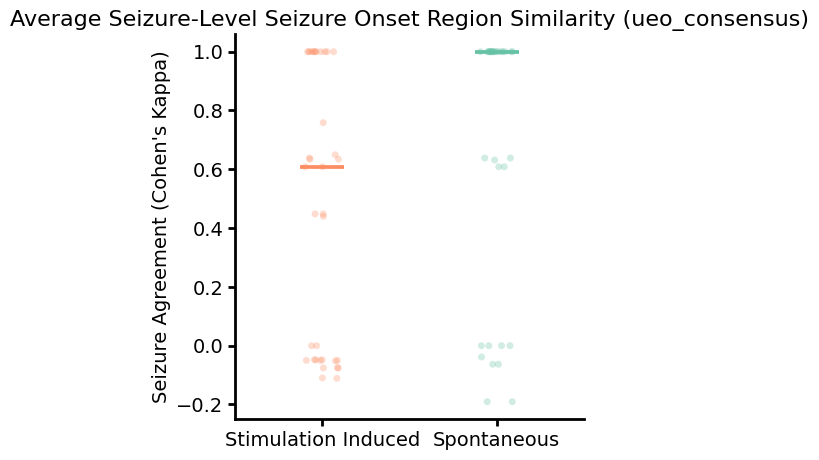

In [25]:
all_stim_annots = []
all_spont_annots = []
all_stim_patients = []
all_spont_patients = []
avg_stim_annots = []
avg_spont_annots = []
annot_type = 'ueo'
con_type = 'consensus'
for pt,group in annotations_df.groupby("patient"):
    
    if len(group) < 2:
        continue

    spont_dices=[]
    stim_dices=[]
    spont_kappas=[]
    stim_kappas=[]
    for i in range(len(group)):
        group.reset_index(drop=True,inplace=True)
        all_rs = group.loc[i,'all_rs']
        chs = group.loc[i,f'{annot_type}_{con_type}_rs']
        ch_mask = [r in chs for r in all_rs]
        for j in range(i+1,len(group)):
            if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                continue
            chs2 = group.loc[j,f'{annot_type}_{con_type}_rs']
            ch_mask2 = [r in chs2 for r in all_rs]
            if (group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1):
                stim_kappas.append(cohen_kappa_score(ch_mask,ch_mask2))
            else:
                spont_kappas.append(cohen_kappa_score(ch_mask,ch_mask2))

    avg_stim_annots.append(np.nanpercentile(stim_kappas,75))
    avg_spont_annots.append(np.nanpercentile(spont_kappas,75))
    all_stim_annots.append(stim_kappas)
    all_spont_annots.append(spont_kappas)
    all_stim_patients.append([pt]*len(stim_kappas))
    all_spont_patients.append([pt]*len(spont_kappas))
    

flat_stim_annots = np.array([item for sublist in all_stim_annots for item in (sublist if isinstance(sublist, list) else [sublist])])
flat_spont_annots = np.array([item for sublist in all_spont_annots for item in (sublist if isinstance(sublist, list) else [sublist])])
flat_stim_patients = np.array([item for sublist in all_stim_patients for item in (sublist if isinstance(sublist, list) else [sublist])])
flat_spont_patients = np.array([item for sublist in all_spont_patients for item in (sublist if isinstance(sublist, list) else [sublist])])

flat_stim_patients = flat_stim_patients[~np.isnan(flat_stim_annots)]
flat_stim_annots = flat_stim_annots[~np.isnan(flat_stim_annots)]
flat_spont_patients = flat_spont_patients[~np.isnan(flat_spont_annots)]
flat_spont_annots = flat_spont_annots[~np.isnan(flat_spont_annots)]
plt.figure(figsize=(4.5,5))
all_xs = np.concatenate((np.zeros((len(flat_stim_annots),)),np.ones((len(flat_spont_annots),))),axis=0)
all_ys = np.concatenate((flat_stim_annots,flat_spont_annots))
all_hues = np.concatenate((flat_stim_patients,flat_spont_patients))
pal = sns.color_palette('Set2')
ax = sns.pointplot(x=all_xs,y=all_ys,errorbar=None,
              markers="_",linestyles="none",
              estimator='median',
              palette = pal[:2][::-1])
plt.setp(ax.collections, sizes=[1000])
sns.stripplot(x=all_xs,y=all_ys,alpha=.3,
            #   hue=all_hues,
              palette = pal[:2][::-1])
#
sns.despine()
plt.xticks([0,1],["Stimulation Induced","Spontaneous"])
plt.ylabel("Seizure Agreement (Cohen's Kappa)")
plt.title(f"Average Seizure-Level Seizure Onset Region Similarity ({annot_type}_{con_type})")
print(sc.stats.mannwhitneyu(flat_stim_annots,flat_spont_annots))
print(cohens_d(flat_stim_annots,flat_spont_annots))

MannwhitneyuResult(statistic=71.5, pvalue=0.5250206989409043)
-0.30078942159554456


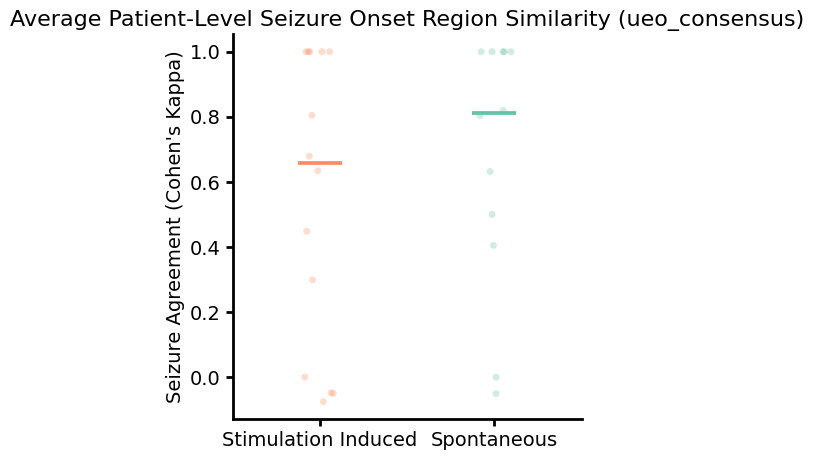

In [26]:
avg_stim_annots = np.array(avg_stim_annots)
avg_stim_annots = avg_stim_annots[~np.isnan(avg_stim_annots)]
avg_spont_annots = np.array(avg_spont_annots)
avg_spont_annots = avg_spont_annots[~np.isnan(avg_spont_annots)]
plt.figure(figsize=(4.5,5))
all_xs = np.concatenate((np.zeros((len(avg_stim_annots),)),np.ones((len(avg_spont_annots),))),axis=0)
all_ys = np.concatenate((avg_stim_annots,avg_spont_annots))
pal = sns.color_palette('Set2')
ax = sns.pointplot(x=all_xs,y=all_ys,errorbar=None,
              markers="_",linestyles="none",
              estimator='median',
              palette = pal[:2][::-1])
plt.setp(ax.collections, sizes=[1000])
sns.stripplot(x=all_xs,y=all_ys,alpha=.3,palette = pal[:2][::-1])
sns.despine()
plt.xticks([0,1],["Stimulation Induced","Spontaneous"])
plt.ylabel("Seizure Agreement (Cohen's Kappa)")
plt.title(f"Average Patient-Level Seizure Onset Region Similarity ({annot_type}_{con_type})")
print(sc.stats.mannwhitneyu(avg_stim_annots,avg_spont_annots))
print(cohens_d(avg_stim_annots,avg_spont_annots))